In [10]:
%cd ~/devel/agn_lf/
# %cd ..
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import numpy as np
from scipy.interpolate import interp1d as intp
from scipy.optimize import curve_fit
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table
import astropy.units as u
import source.selection_criteria as sc
from sklearn.neighbors import KernelDensity

cosmo = af.setup_cosmology()

/Users/runburg/devel/agn_lf


In [11]:
# catalog = table.Table.read('./data/ir_and_xray.fits')
# catalog = table.Table.read('./data/crossmatch_xservs_help_10arcsec.fits')
catalog = table.Table.read('./data/xmatch_catalog_1_arcsec.fits')
# print(catalog.colnames)
outfile = 'lf_ir_crossmatch_ir_selected_fixed_coverage'
specz = 'zspec_1'
photoz = 'redshift'
specz2 = 'ZSPEC_2'
photoz2 = 'ZPHOT'

flux36 = 'f_ap_irac_i1'
flux45 = 'f_ap_irac_i2'
flux58 = 'f_ap_irac_i3'
flux80 = 'f_ap_irac_i4'
flux240 = 'f_mips_24'

# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(catalog[specs], nan=-99) > 0)

selected_agn = sc.select_ir(catalog, flux36, flux45, flux58, flux80, selection_cuts='lacy05')
ir_ct_lacy = catalog[selected_agn]


######## SAVING CATALOG FOR ANNAS STUDENTS
# catalog['lacy05 selected'] = selected_agn

# selected_agn1 = sc.select_ir(catalog, flux36, flux45, flux58, flux80, selection_cuts='stern05')
# catalog['stern05 selected'] = selected_agn1

# selected_agn1 = sc.select_ir(catalog, flux36, flux45, flux58, flux80, selection_cuts='donley12')
# catalog['donley12 selected'] = selected_agn1

# catalog.write('./data/agn_catalog_crossmatch_HELP_XSERVS.fits')
########

ct_lacy = ir_ct_lacy[(np.nan_to_num(ir_ct_lacy[photoz], nan=-99) > 0 ) | (np.nan_to_num(ir_ct_lacy[specz], nan=-99) > 0)]
# print(len(ct_lacy))
# band + units
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
zs = np.array([row[specz] if row[specz] > 0 else row[photoz] if row[photoz] > 0 else row[specz2] if row[specz2] > 0 else row[photoz2] for row in catalog])
# print(np.sum(zs < 0))
spectral_index = np.log10(catalog[flux240].data/catalog[flux58].data) / np.log10(24/5.8)

catalog['ir_selected'] = selected_agn.astype(bool).filled(False)
catalog['ir_l'] = 4 * np.pi * cosmo.luminosity_distance(zs).to(u.cm).value**2 * catalog[flux58].data * unit_conversion * (1 + zs)**(-1 + spectral_index)


# xzs = np.array([row[specz] if row[specz] > 0 else row[photoz] for row in catalog])
xzs = np.array([row[specz2] if row[specz2] > 0 else row[photoz2] if row[photoz2] > 0 else row[specz] if row[specz] > 0 else row[photoz] for row in catalog])
spectral_index = np.log10(catalog['HB_FLUX'].data/catalog['SB_FLUX'].data) / np.log10(6/1.25)
catalog['x_l'] = 4 * np.pi * cosmo.luminosity_distance(xzs).to(u.cm).value**2 * catalog['FB_FLUX'] * (1 + xzs)**(-1 + spectral_index)
catalog['x_selected'] = (catalog['x_l'] > 3e42).filled(False)
# print(catalog['x_selected'])
catalog['both_selected_and_good'] = catalog['x_selected'] & catalog['ir_selected'] & ~catalog['x_l'].mask & ~catalog['ir_l'].mask

print('xray selected\t ir selected\t both selected')
print(np.sum(catalog['x_selected']), np.sum(catalog['ir_selected']), np.sum(catalog['both_selected_and_good']))

catalog['full_zs'] = np.array([row[specz2] if row[specz2] > 0 else row[specz] if row[photoz2] > 0 else row[photoz2] if row[specz] > 0 else row[photoz] if row[photoz] > 0 else np.nan for row in catalog])
print(len(zs), len(xzs))

ra_up = 36.5
ra_down = 34.25
dec_up = -4.0
dec_down = -5.5 
catalog = catalog[(ra_down < catalog['RA_2']) & (catalog['RA_2'] < ra_up)& (dec_down < catalog['DEC_2']) & (catalog['DEC_2'] < dec_up)]
    
print('xray selected\t ir selected\t both selected')
print(np.sum(catalog['x_selected']), np.sum(catalog['ir_selected']), np.sum(catalog['both_selected_and_good']))

# band + units
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
flux_limit = 43 * unit_conversion

# K-correction
spectral_index = np.log10(ct_lacy[flux240].data/ct_lacy[flux58].data) / np.log10(24/5.8)

cross_z_ir = np.array([row[specz] if row[specz] > 0 else row[photoz] for row in ct_lacy])

cross_l_ir = 4 * np.pi * cosmo.luminosity_distance(cross_z_ir).to(u.cm).value.astype(np.float64)**2 * ct_lacy[flux58].data * unit_conversion * (1 + cross_z_ir)**(-1 + spectral_index)

specz = 'redshift'
photoz = 'ZPHOT'
ct_lacy = catalog[(np.nan_to_num(catalog[photoz], nan=-99) > 0 ) | (np.nan_to_num(catalog[specz], nan=-99) > 0)]

cross_z_x = np.array([row[specz] if row[specz] > 0 else row[photoz] for row in ct_lacy])

spectral_index = np.log10(ct_lacy['HB_FLUX'].data/ct_lacy['SB_FLUX'].data) / np.log10(6/1.25)

cross_l_x = 4 * np.pi * cosmo.luminosity_distance(cross_z_x).to(u.cm).value.astype(np.float64)**2 * ct_lacy['FB_FLUX'] * (1 + cross_z_x)**(-1 + spectral_index)


cross_cat = catalog

# print(len(cross_z_ir), len(cross_z_x))
print(len(cross_cat))

AttributeError: 'numpy.ndarray' object has no attribute 'filled'

In [12]:
catalog = table.Table.read('./data/help_full_catalog_with_fluxes_and_redshifts.fits')
print('total object in help catalog', len(catalog))
outfile = 'lf_ir_montecarlo_with_incompleteness'
specz = 'zspec' 
photoz = 'redshift'

flux36 = 'f_ap_irac_i1'
flux45 = 'f_ap_irac_i2'
flux58 = 'f_ap_irac_i3'
flux80 = 'f_ap_irac_i4'
flux240 = 'f_mips_24'

FileNotFoundError: [Errno 2] No such file or directory: './data/help_full_catalog_with_fluxes_and_redshifts.fits'

In [4]:
# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(catalog[specs], nan=-99) > 0)

selected_agn = sc.select_ir(catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')

####### SAVING CATALOG FOR ANNAS STUDENTS
# selected_agn1 = sc.select_ir(catalog, flux36, flux45, flux58, flux80, selection_cuts='lacy05')
# catalog['lacy05 selected'] = selected_agn1

# selected_agn1 = sc.select_ir(catalog, flux36, flux45, flux58, flux80, selection_cuts='stern05')
# catalog['stern05 selected'] = selected_agn1

# selected_agn1 = sc.select_ir(catalog, flux36, flux45, flux58, flux80, selection_cuts='donley12')
# catalog['donley12 selected'] = selected_agn1

# catalog.write('./data/agn_catalog_HELP.fits')
########

ct_lacy = catalog[never_nan][selected_agn]
ct_lacy = ct_lacy[(np.nan_to_num(ct_lacy[photoz], nan=-99) > 0 ) | (np.nan_to_num(ct_lacy[specz], nan=-99) > 0)]
print('total selected agn', len(ct_lacy))
print('number of photzs', (np.nan_to_num(ct_lacy[photoz], nan=-99) > 0).sum(), '\n number of speczs', (np.nan_to_num(ct_lacy[specz], nan=-99) > 0).sum())
cosmo = af.setup_cosmology()
# catalog = ct_lacy

ir_in_cross_region = (ra_down < catalog['ra']) & (catalog['ra'] < ra_up)& (dec_down < catalog['dec']) & (catalog['dec'] < dec_up)
# band + units
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
flux_limit = 43 * unit_conversion

# K-correction
spectral_index = np.log10(ct_lacy[flux240].data/ct_lacy[flux58].data) / np.log10(24/5.8)

ir_z = np.array([row[specz] if row[specz] > 0 else row[photoz] for row in ct_lacy])

ir_l = 4 * np.pi * cosmo.luminosity_distance(ir_z).to(u.cm).value.astype(np.float64)**2 * ct_lacy[flux58].data * unit_conversion * (1 + ir_z)**(-1 + spectral_index)
print(len(ir_z[(ir_z > 0.5) & (ir_z < 4)]))

goodindices = (np.nan_to_num(ct_lacy['zspec'], nan=-99) > 0) & (np.nan_to_num(ct_lacy['redshift'], nan=-99) > 0)
helpzs = ct_lacy['zspec'][goodindices]
xservszs = ct_lacy['redshift'][goodindices]
diffs = np.abs(helpzs - xservszs) / (1 + helpzs) 
sigmanmad = 1.48 * np.median(diffs)
outliers = diffs > 3 * sigmanmad
print(r'$\sigma_\mathrm{nmad}$', sigmanmad)
print('outlier frac', np.sum(outliers)/len(outliers)*100, '%')

total selected agn 5918
number of photzs 5847 
 number of speczs 2283
4408
$\sigma_\mathrm{nmad}$ 0.07829503446817399
outlier frac 24.141048824593128 %


/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [5]:
selected_agn = sc.select_ir(cross_cat, flux36, flux45, flux58, flux80, selection_cuts='lacy05')
print(np.sum(selected_agn))
print(np.sum(cross_l_x > 3e42))

958
1069


In [6]:
xservs_catalog = table.Table.read('./data/tableA.v01.fits')
print('toal sources in catalgo', len(xservs_catalog))
xservs_catalog = xservs_catalog[(xservs_catalog['ZPHOT'] > 0 ) | (xservs_catalog['ZSPEC'] > 0)]

print('number of photzs', (np.nan_to_num(xservs_catalog['ZPHOT'], nan=-99) > 0).sum(), '\n number of speczs', (np.nan_to_num(xservs_catalog['ZSPEC'], nan=-99) > 0).sum())
spectral_index = np.log10(xservs_catalog['HB_FLUX'].data/xservs_catalog['SB_FLUX'].data) / np.log10(6/1.25)

z = np.array([row['ZSPEC'] if row['ZSPEC'] > 0 else row['ZPHOT'] for row in xservs_catalog])

l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2 * xservs_catalog['FB_FLUX'] * (1 + z)**(-1 + spectral_index)

selected_agn = l > 3e42
print('selected agn', len(selected_agn))

####### SAVING CATALOG FOR ANNAS STUDENTS
# xservs_catalog['x-ray selected'] = selected_agn

# xservs_catalog.write('./data/agn_catalog_XSERVS.fits')
########
goodindices = (np.nan_to_num(xservs_catalog['ZSPEC'], nan=-99) > 0) & (np.nan_to_num(xservs_catalog['ZPHOT'], nan=-99) > 0)
helpzs = xservs_catalog['ZSPEC'][goodindices]
xservszs = xservs_catalog['ZPHOT'][goodindices]
diffs = np.abs(helpzs - xservszs) / (1 + helpzs) 
sigmanmad = 1.48 * np.median(diffs)
outliers = diffs > 3 * sigmanmad
print(r'$\sigma_\mathrm{nmad}$', sigmanmad)
print('outlier frac', np.sum(outliers)/len(outliers)*100, '%')

toal sources in catalgo 5242
number of photzs 3419 
 number of speczs 1767
selected agn 4505
$\sigma_\mathrm{nmad}$ 0.05288705310760072
outlier frac 20.11747430249633 %


In [7]:
catalog = xservs_catalog[selected_agn]
x_in_cross_region = (ra_down < catalog['RA']) & (catalog['RA'] < ra_up)& (dec_down < catalog['DEC']) & (catalog['DEC'] < dec_up)

x_l = l[selected_agn]
x_z = z[selected_agn]

band_correction = (catalog['FB_FLUX'] / catalog['HB_FLUX']).mean()
print(band_correction, (catalog['FB_FLUX'] / catalog['HB_FLUX']).std())
print(len(l))

1.0576234855566566 0.7470945101666551
4505


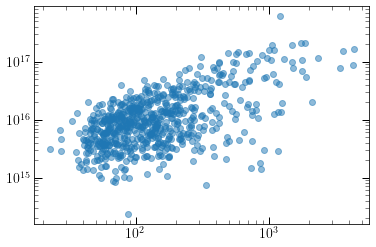

In [8]:
utils.configure_plot_params()
sources = cross_cat['redshift'] < 1.5
ratio = cross_cat[sources][flux58]/cross_cat[sources]['FB_FLUX']
plt.scatter(cross_cat[sources][flux58], ratio, alpha=0.5)
plt.xscale('log')
plt.yscale('log')

0
[ 0.52409327 20.72407868]


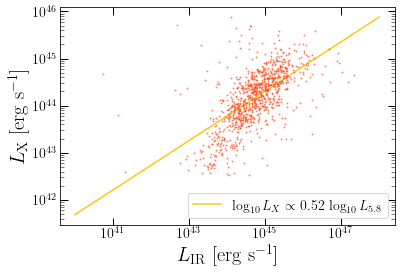

In [9]:
fig, ax = plt.subplots()

ax.scatter(cross_cat['ir_l'][cross_cat['both_selected_and_good']], cross_cat['x_l'][cross_cat['both_selected_and_good']], color='xkcd:orangered', s=1, alpha=0.5)
ax.set_xlabel(r'$L_\mathrm{IR}$ [erg s$^{-1}$]')
ax.set_ylabel(r'$L_\mathrm{X}$ [erg s$^{-1}$]')
ax.set_xscale('log')
ax.set_yscale('log')

# print(np.sum(np.isnan(cross_cat['x_l'][cross_cat['ir_selected']].filled(np.nan))))
def exp_fit(x, A, b, c):
    return A * x**b + c

def lin_fit(x, m, b):
    return m * x + b
# def lin_fit(x, m):
#     return m * x
print(np.sum(np.isinf(cross_cat['x_l'][cross_cat['both_selected_and_good']])))

# fitparams, fitcov = curve_fit(exp_fit, cross_cat['ir_l'][cross_cat['both_selected_and_good']], cross_cat['x_l'][cross_cat['both_selected_and_good']], p0=[1, 1, 50], bounds=([1, 0, 0], [1e16, 3, 1e3]))
fitparams, fitcov = curve_fit(lin_fit, np.log10(cross_cat['ir_l'][cross_cat['both_selected_and_good']]), np.log10(cross_cat['x_l'][cross_cat['both_selected_and_good']]), p0=[3, -90])
print(fitparams)
ls = np.logspace(40, 48, num=50)
ax.plot(ls, 10**lin_fit(np.log10(ls), *fitparams), color='xkcd:golden yellow', zorder=-5, label=rf'$\log_{{10}}L_X\propto {fitparams[0]:.2f}\,\log_{{10}}L_{{5.8}}$')

ax.plot(ls, 10**(0.4 * (np.log10(ls) - 45) + 44.51, color='kxcd:steel', zorder=-10, label='Chen+17')
# ax.plot(ls, exp_fit(ls, *fitparams), color='xkcd:golden yellow', zorder=-5, label=rf'$\log_{{10}}L_X\propto {fitparams[1]:.2f}\,\log_{{10}}L_{{IR}}$')
# ax.fill_between(ls, exp_fit(ls, *(fitparams - np.sqrt(np.diag(fitcov)))), exp_fit(ls, *(fitparams + np.sqrt(np.diag(fitcov)))), color='xkcd:golden yellow', zorder=-5, alpha=0.5)
ax.legend()
fig.savefig('./output/paper_plots/lir_vs_lx.pdf', bbox_inches='tight')

0.5240932859164806
[20.72407792  0.52409329]
20.724077921413986 + 0.5240932859164806·x¹
44.30827578765562


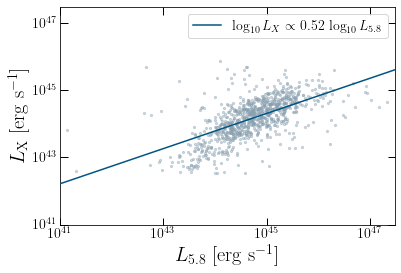

In [10]:
fig, ax = plt.subplots()

ax.scatter(cross_cat['ir_l'][cross_cat['both_selected_and_good']], cross_cat['x_l'][cross_cat['both_selected_and_good']], color='xkcd:bluey grey', s=5, alpha=0.4)
ax.set_xlabel(r'$L_{5.8}$ [erg s$^{-1}$]')
ax.set_ylabel(r'$L_\mathrm{X}$ [erg s$^{-1}$]')
ax.set_xscale('log')
ax.set_yscale('log')

# # print(np.sum(np.isnan(cross_cat['x_l'][cross_cat['ir_selected']].filled(np.nan))))
# def exp_fit(x, A, b, c):
#     return A * x**b + c

# def lin_fit(x, m, b):
#     return m * x + b
# # def lin_fit(x, m):
# #     return m * x
# print(np.sum(np.isinf(cross_cat['x_l'][cross_cat['both_selected_and_good']])))

# # fitparams, fitcov = curve_fit(exp_fit, cross_cat['ir_l'][cross_cat['both_selected_and_good']], cross_cat['x_l'][cross_cat['both_selected_and_good']], p0=[1, 1, 50], bounds=([1, 0, 0], [1e16, 3, 1e3]))
# fitparams, fitcov = curve_fit(lin_fit, np.log10(cross_cat['ir_l'][cross_cat['both_selected_and_good']]), np.log10(cross_cat['x_l'][cross_cat['both_selected_and_good']]), p0=[3, -90])
# print(fitparams)
import numpy.polynomial.polynomial as poly

seriesfit = poly.Polynomial.fit(np.log10(cross_cat['ir_l'][cross_cat['both_selected_and_good']]), np.log10(cross_cat['x_l'][cross_cat['both_selected_and_good']]), 1)

ls = np.logspace(40, 48, num=50)
seriesfit = seriesfit.convert()
ax.plot(ls, 10**seriesfit(np.log10(ls)), color='xkcd:deep sea blue', zorder=5, label=rf'$\log_{{10}}L_X\propto {seriesfit.coef[1]:.2f}\,\log_{{10}}L_{{5.8}}$')
# ax.plot(ls, exp_fit(ls, *fitparams), color='xkcd:golden yellow', zorder=-5, label=rf'$\log_{{10}}L_X\propto {fitparams[1]:.2f}\,\log_{{10}}L_{{IR}}$')
# ax.fill_between(ls, exp_fit(ls, *(fitparams - np.sqrt(np.diag(fitcov)))), exp_fit(ls, *(fitparams + np.sqrt(np.diag(fitcov)))), color='xkcd:golden yellow', zorder=-5, alpha=0.5)
ax.legend()
ax.set_ylim(bottom=1e41, top=3e47)
ax.set_xlim(left=1e41, right=3e47)
fig.savefig('./output/paper_plots/lir_vs_lx.pdf', bbox_inches='tight')
print(seriesfit.coef[1])
print(seriesfit.convert().coef)
print(seriesfit)
print(seriesfit(45))

In [11]:
plot_files = ['./output/lf_xray.npz', './output/lf_ir.npz']
labs = ['XLF', 'IRLF']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
        l_bins = infile['l_bins']
        z_bins = infile['z_bins']
    otherruns[lab] = [lfv, lfe, l_bins, z_bins]

In [12]:
yencho_ldde = {'A': 10**-6.12, 
               'gamma1': 0.956, 
               'gamma2': 2.3,
               'Lstar': 10**44.078,
               'zcstar': 1.964,
               'p1': 5.13,
               'p2': -2.51,
               'alpha': 0.255,
               'La': 10**44.889
              }
silverman_ldde = {'A': 10**-6.163, 
               'gamma1': 2.15, 
               'gamma2': 1.10,
               'Lstar': 10**44.33,
               'zcstar': 1.89,
               'p1': 4.22,
               'p2': -3.27,
               'alpha': 0.333,
               'La': 10**44.6
              }
aird_ldde = {'A': 10**-6.08, 
               'gamma1': 0.77, 
               'gamma2': 2.80,
               'Lstar': 10**44.42,
               'zcstar': 1.27,
               'p1': 4.64,
               'p2': -1.69,
               'alpha': 0.333,
               'La': 10**44.7
              }
ranalli_ldde = {'A': 10**-5.67, 
               'gamma1': 0.90, 
               'gamma2': 2.51,
               'Lstar': 10**44.05,
               'zcstar': 2.10,
               'p1': 5.08,
               'p2': -1.90,
               'alpha': 0.39,
               'La': 10**44.7
              }
hz_convert = 5.8e-6 / 3e8
lacy_ir_evol_params_central = {'A': 10**-4.75, 
                               'gamma1':1.07, 
                               'gamma2':2.48,
                               'Lstar': 10**31.92 / hz_convert,
                               'zref':2.5,
                               'k1':1.05,
                               'k2':-4.71,
                               'k3':-0.034
                              }

In [13]:
# Zavala IRLF
def zavala_lf(z, l, alpha=-0.42, beta=1.8, psi1=0, psi2=-6.5, phi0=10**-3.5, l0=10**11.1*3.83e33):
    zturn = 1.6 - 0.09 * psi2
    gamma1 = 2.8
    gamma2 = 1
    
    phi_star = phi0 * np.where(z >= zturn, (1+z)**psi2, (1+z)**psi1)
    l_star = l0 * np.where(z >= zturn, (1+z)**gamma2, (1+z)**gamma1)
    
    irlfval = phi_star[:, np.newaxis] * (l[np.newaxis, :] / l_star[:, np.newaxis]) ** np.where(l[np.newaxis, :] >= l_star[:, np.newaxis], alpha, beta)
    return irlfval

In [14]:
# xray = otherruns['XLF']
# ir = otherruns['IRLF']
# # xray[0][2][2] = (xray[0][2][1] + xray[0][2][3])/2 

# l_bins = (xray[2][:-1] + xray[2][1:])/2
# z_bins = (xray[3][:-1]  + xray[3][1:])/2

# flux_limit = 6.5e-15
# l_limits = 4 * np.pi * cosmo.luminosity_distance(z_bins)**2 * flux_limit/(u.cm**2)
# # l_limits = 4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2)
# l_limits = l_limits.decompose()

# for lim, lf in zip(l_limits, xray[0]):
#     lum_lim_index = np.argmax(lim < l_bins)
#     lf[:lum_lim_index] = 0

# wavelength = 5.8
# unit_conversion = 3 / wavelength * 1e-15
# flux_limit = 43 * unit_conversion
# l_limits = 4 * np.pi * cosmo.luminosity_distance(z_bins)**2 * flux_limit/(u.cm**2)
# l_limits = l_limits.decompose()

# # print(len(ir), l_limits.shape)
# for lim, lf in zip(l_limits, ir[0]):
#     lum_lim_index = np.argmax(lim < l_bins)
# #     print(lum_lim_index)
#     lf[:lum_lim_index] = 0
    
# xmarker = 'H'
# irmarker = 'P'
# xcolor = 'xkcd:purplish blue'
# ircolor = 'xkcd:tomato'
# colors = ['xkcd:petrol', 'xkcd:royal', 'xkcd:red wine', 'xkcd:lilac', 'xkcd:cerulean', 'xkcd:aquamarine', 'xkcd:wine', 'xkcd:coral', 'xkcd:seafoam green']
# lss = [(0, (3, 1, 1, 1)), (0, (5, 5)), (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5))]

# i = 3
# j = -7
# # print('Lum range:', l_bins[i], 'to', l_bins[-1], np.log10(l_bins[i]), np.log10(l_bins[j]))
# fig, ax = plt.subplots()
# num_density = np.trapz(xray[0][:, i:j], l_bins[i:j], axis=1)
# print(num_density)
# xrayplot = ax.scatter(z_bins, num_density, label='X-ray', color=xcolor, zorder=100, marker=xmarker)

# ir_high = np.argmax(l_bins >= (l_bins[j]/10**fitparams[1])**(1/fitparams[0]))
# ir_low = np.argmax(l_bins >= (l_bins[i]/10**fitparams[1])**(1/fitparams[0]))
# # print(10**lin_fit(np.log10(l_bins[i:j]), *fitparams))
# print(ir_low, ir_high)
# num_density = np.trapz(ir[0][:, ir_low:ir_high], l_bins[ir_low:ir_high], axis=1)

# print(num_density)
# irplot = ax.scatter(z_bins, num_density, label='IR', color=ircolor, zorder=100, marker=irmarker)
# # ax.scatter(z_bins, num_density, label='IR '+'{:.2f}'.format(np.log10(l_bins[ir_low])) +  r' $\leq \log_{10} L_{IR}/$erg s$^{-1} \leq$ ' + '{:.2f}'.format(np.log10(l_bins[ir_high])), color=ircolor, zorder=100, marker=irmarker)

# # print(xray[0])
# numde = np.sum(-(xray[2][:-1]-xray[2][1:])/2*xray[0], axis=1)
# # ax.scatter(z_bins, numde, label='XLF2')
# ax.set_yscale('log')
# # lgd = ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
# ax.set_ylim(bottom=1e-7, top=3e-4)
# ax.set_xlabel('Redshift')
# ax.set_ylabel(r'Number density [Mpc$^{-3}$]')
# # ax.set_title('{:.2f}'.format(np.log10(l_bins[i])) +  r' $\leq \log_{10} L_X/$erg s$^{-1} \leq$ ' + '{:.2f}'.format(np.log10(l_bins[-1])))


# # print(numde)
# # print(z_bins)
# # print(l_bins)

# lines = (ls for ls in lss)
# colo = (c for c in colors)

# ls = np.logspace(np.log10(l_bins[i]), np.log10(l_bins[j]), num=200)
# yencho_mid = af.LDDE(ls, z_bins, **yencho_ldde)
# yencho_num = np.trapz(yencho_mid[:, :, 1] / ls, ls, axis=1)
# yencho, = ax.plot(z_bins, yencho_num, label='Yencho+09', color=next(colo), ls=next(lines))
# silverman_mid = af.LDDE(ls, z_bins, **silverman_ldde)
# silverman_num = np.trapz(silverman_mid[:, :, 1] / ls, ls, axis=1)
# silverman, = ax.plot(z_bins, silverman_num, label='Silverman+08', color=next(colo), ls=next(lines))
# aird_mid = af.LDDE(ls, z_bins, **aird_ldde)
# aird_num = np.trapz(aird_mid[:, :, 1] / ls, ls * band_correction, axis=1)
# aird, = ax.plot(z_bins, aird_num, label='Aird+10', color=next(colo), ls=next(lines))
# ranalli_mid = af.LDDE(ls, z_bins, **ranalli_ldde)
# ranalli_num = np.trapz(ranalli_mid[:, :, 1] / ls, ls, axis=1)
# ranalli, = ax.plot(z_bins, ranalli_num, label='Ranalli+16', color=next(colo), ls=next(lines))

# # print(silverman_num)
# lgd = ax.legend(handles=[xrayplot, irplot], loc='lower left')
# ax.add_artist(lgd)
# ax.legend(handles=[yencho, silverman, aird, ranalli], loc='upper right')
# fig.savefig('./output/paper_plots/num_density.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')


In [15]:
# i = 3 
# j =  8
# print('Lum range:', l_bins[i], 'to', l_bins[-1])
# # x_high = np.argmax(l_bins >= )
# # x_low = np.argmax(l_bins >= (l_bins[i] * 40 / 10))
                   
# ls = np.logspace(np.log10(l_bins[i]), np.log10(l_bins[j]), num=200)

# lum_density = np.trapz(l_bins[i:j] * xray[0][:, i:j], l_bins[i:j], axis=1)

# fig, ax = plt.subplots()
# lines = (ls for ls in lss)
# colo = (c for c in colors)

# xrayplot = ax.scatter(z_bins, 40**2*lum_density, label='X-ray sample', color=xcolor, marker=xmarker)

# ir_high = np.argmax(l_bins >= (l_bins[j] * 40 / 10))
# ir_low = np.argmax(l_bins >= (l_bins[i] * 40 / 10))

# lum_density = np.trapz(l_bins[ir_low:ir_high] * ir[0][:, ir_low:ir_high], l_bins[ir_low:ir_high], axis=1)
# irplot = ax.scatter(z_bins, 10**2*lum_density, label='IR sample', color=ircolor, marker=irmarker)
# ax.set_yscale('log')
# ax.set_xlabel('Redshift')
# ax.set_ylabel(r'Lum. density [erg s$^{-1}$ Mpc$^{-3}$]')

# yencho_lum = np.trapz(yencho_mid[:, :, 1], ls, axis=1)
# yencho, = ax.plot(z_bins, 40**2*yencho_lum, label='Yencho+09', color=next(colo), ls=next(lines))
# silverman_lum = np.trapz(silverman_mid[:, :, 1], ls, axis=1)
# silverman, = ax.plot(z_bins, 40**2*silverman_lum, label='Silverman+08', color=next(colo), ls=next(lines))
# aird_lum = np.trapz(aird_mid[:, :, 1], ls, axis=1)
# aird, = ax.plot(z_bins, 40**2*aird_lum, label='Aird+10', color=next(colo), ls=next(lines))
# ranalli_lum = np.trapz(ranalli_mid[:, :, 1], ls, axis=1)
# ranalli, = ax.plot(z_bins, 40**2*ranalli_lum, label='Ranalli+16', color=next(colo), ls=next(lines))

# # aird_trial = np.loadtxt('./data/lum_dens_42_all.csv', delimiter=',')
# # ax.plot(aird_trial[:, 0], aird_trial[:, 1], label=r'Aird $L_X > 10^{42}$ erg s$^{-1}$')
# # aird_trial = np.loadtxt('./data/lum_dens_42_43.csv', delimiter=',')
# # ax.plot(aird_trial[:, 0], aird_trial[:, 1], label=r'Aird $10^{43} > L_X > 10^{42}$ erg s$^{-1}$')
# # aird_trial = np.loadtxt('./data/lum_dens_43_44.csv', delimiter=',')
# # ax.plot(aird_trial[:, 0], aird_trial[:, 1], label=r'Aird $10^{44} > L_X > 10^{43}$ erg s$^{-1}$')

# lgd = ax.legend(handles=[xrayplot, irplot], loc='lower left')
# ax.add_artist(lgd)
# ax.legend(handles=[yencho, silverman, aird, ranalli], loc='lower right')
# # lgd = ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
# # plt.ylim(bottom=1e39)

# fig.savefig('./output/paper_plots/lum_density.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

Lum range: 44.5 to 46
ir ls 2.321778448452122e+45 1.6900776872824265e+48 45.36582077560699 48.227906668153686


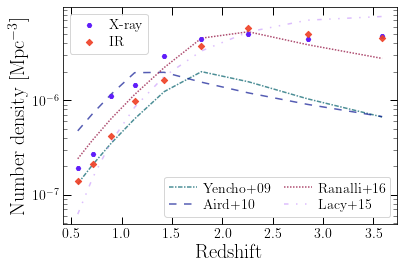

In [19]:
xray = otherruns['XLF']
ir = otherruns['IRLF']

llow = 44.5
lhigh = 46
ellow = llow
elhigh = lhigh

comparison_alpha = 0.7
ms = 20

print('Lum range:', llow, 'to', lhigh)

xmarker = 'H'
irmarker = 'D'
xcolor = 'xkcd:purplish blue'
ircolor = 'xkcd:tomato'
colors = ['xkcd:petrol', 'xkcd:royal', 'xkcd:red wine', 'xkcd:lilac', 'xkcd:cerulean', 'xkcd:aquamarine', 'xkcd:wine', 'xkcd:coral', 'xkcd:seafoam green']
lss = [(0, (3, 1, 1, 1)), (0, (5, 5)), (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (1, 8))]

fig, ax = plt.subplots()

ls = np.logspace(llow, lhigh, num=200)
l_bins = xray[2]
z_bins = (xray[3][:-1]  + xray[3][1:])/2

amps = np.array([-4.2, -4.3, -4.4, -4.5, -4.6, -4.6, -4.7, -4.9, -5.0])
gamma1s = np.array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5])
gamma2s = np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5])
Lstars = np.array([43.8, 43.9, 44.2, 44.3, 44.5, 44.6, 44.7, 44.8, 44.9])

param_list=np.array([amps, gamma1s, gamma2s, Lstars]).T
dpls = af.dpl_fit(xray[0], xray[1][:, 1], l_bins, beta0s=param_list)
num_density = np.array([np.trapz(dpl(ls) / ls, ls) for dpl in dpls])
xrayplot = ax.scatter(z_bins, num_density / np.log(10), label='X-ray', color=xcolor, zorder=100, marker=xmarker, s=ms)


amps = np.array([-4.4, -4.4, -4.4, -4.5, -4.7, -4.9, -5.0, -5.2, -5.6])
gamma1s = np.array([1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8])
gamma2s = np.array([2.5, 2.6, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5])
Lstars = np.array([44.7, 44.8, 44.9, 45.1, 45.3, 45.6, 45.8, 45.9, 46.2])
ir_param_list=np.array([amps, gamma1s, gamma2s, Lstars]).T
irdpls = af.dpl_fit(ir[0], ir[1][:, 1], l_bins, beta0s=ir_param_list, ifixb=[1, 0, 0, 1])
# irls = (ls/10**fitparams[1])**(1/fitparams[0])
irls = 10**((np.log10(ls) - seriesfit.coef[0])/seriesfit.coef[1])

print('ir ls', irls[0], irls[-1], np.log10(irls[0]), np.log10(irls[-1]))
num_density = np.array([np.trapz(dpl(irls) / irls, irls) for dpl in irdpls])

irplot = ax.scatter(z_bins, num_density / np.log(10), label='IR', color=ircolor, zorder=100, marker=irmarker, s=ms, alpha=0.9)

ax.set_yscale('log')
# ax.set_ylim(bottom=5e-8, top=3e-5)
ax.set_xlabel('Redshift')
ax.set_ylabel(r'Number density [Mpc$^{-3}$]')

lines = (ls for ls in lss)
colo = (c for c in colors)

yencho_mid = af.LDDE(ls, z_bins, **yencho_ldde)
yencho_num = np.trapz(yencho_mid[:, :, 1] / ls, ls, axis=1)
yencho, = ax.plot(z_bins, yencho_num / np.log(10), label='Yencho+09', color=next(colo), ls=next(lines), alpha=comparison_alpha)
# silverman_mid = af.LDDE(ls, z_bins, **silverman_ldde)
# silverman_num = np.trapz(silverman_mid[:, :, 1] / ls, ls, axis=1)
# silverman, = ax.plot(z_bins, silverman_num / np.log(10), label='Silverman+08', color=next(colo), ls=next(lines))
aird_mid = af.LDDE(ls, z_bins, **aird_ldde)
aird_num = np.trapz(aird_mid[:, :, 1] / ls, ls * band_correction, axis=1)
aird, = ax.plot(z_bins, aird_num / np.log(10), label='Aird+10', color=next(colo), ls=next(lines), alpha=comparison_alpha)
ranalli_mid = af.LDDE(ls, z_bins, **ranalli_ldde)
ranalli_num = np.trapz(ranalli_mid[:, :, 1] / ls, ls, axis=1)
ranalli, = ax.plot(z_bins, ranalli_num / np.log(10), label='Ranalli+16', color=next(colo), ls=next(lines), alpha=comparison_alpha)

lacy_mid = af.IR_evol(irls, z_bins, **lacy_ir_evol_params_central)
lacy_num = np.trapz(lacy_mid[:, :, 1] / irls, irls, axis=1)
lacy, = ax.plot(z_bins, lacy_num / np.log(10), label='Lacy+15', color=next(colo), ls=next(lines), alpha=comparison_alpha)

# zls = np.logspace(9, 13.8) * 3.83e33
# zavala_mi = zavala_lf(z_bins, zls)
# zavala_num = np.trapz(zavala_mi, np.log10(zls), axis=1)
# zavala, = ax.plot(z_bins, zavala_num / np.log(10), label='Zavala+21', color=next(colo), ls=next(lines))

legend_kw = {'borderpad': 0.4, 'labelspacing': 0.3, 'handletextpad': 0.4, 'columnspacing': 1.0}

lgd = ax.legend(handles=[xrayplot, irplot], loc='upper left', **legend_kw)
ax.add_artist(lgd)
ax.legend(handles=[yencho, aird, ranalli, lacy], loc='lower right', ncol=2, **legend_kw)
fig.savefig('./output/paper_plots/num_density.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

# print(zavala_mi[0, ::20])
# print(lacy_mid[0, ::20, 1])

log bolo l interval 45.84435352828582 47.84405666344347
2.4304968413574376e+44 2.562036971882152e+45
(9,) (9,)


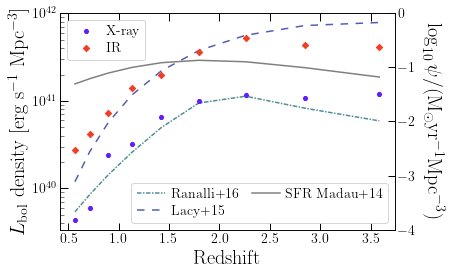

In [20]:
# x_high = np.argmax(l_bins >= )
# x_low = np.argmax(l_bins >= (l_bins[i] * 40 / 10))

fig, ax = plt.subplots()
lines = (ls for ls in lss)
colo = (c for c in colors)

xbolo = 40
irbolo = 10


def xbolo_corr(lx, a=15.33, b=11.48, c=16.20):
    return a * (1 + (np.log10(lx / 3.846e33)/b)**c)
# def xbolo_corr(*args, **kwargs):
#     return 40
llow += np.log10(xbolo_corr(10**llow))
lhigh += np.log10(xbolo_corr(10**lhigh))


ls = np.logspace(llow, lhigh, num=200)
print('log bolo l interval', llow, lhigh)
# print('bolo l interval', ls[0] * xbolo_corr(ls[0]), ls[-1] * xbolo_corr(ls[-1]), np.log10(ls[0] * xbolo_corr(ls[0])), np.log10(ls[-1] * xbolo_corr(ls[-1])))

xls = ls / xbolo_corr(ls, a=10.96, b=11.93, c=17.79)
print(xls[0], xls[-1])
# dpls = af.dpl_fit(xray[0], xray[1][:, 1], l_bins, beta0=[np.log10(7e-5), 0.3, 2.9, np.log10(4e44)])
lum_density = np.array([np.trapz(dpl(xls), xbolo_corr(xls)*xls) for dpl in dpls])
print(lum_density.shape, z_bins.shape)
xrayplot = ax.scatter(z_bins, lum_density / np.log(10), label='X-ray', color=xcolor, zorder=100, marker=xmarker, s=ms)

# dpls = af.dpl_fit(ir[0], ir[1][:, 1], l_bins, beta0=[np.log10(8e-5), 0.7, 2.9, np.log10(4e44)])
# irls = (ls/10**fitparams[1])**(1/fitparams[0])
irls = ls / irbolo
lum_density = np.array([np.trapz(dpl(irls), irls) for dpl in irdpls])

irplot = ax.scatter(z_bins, irbolo*lum_density / np.log(10), label='IR', color=ircolor, zorder=100, marker=irmarker, s=ms)

ax.set_yscale('log')
ax.set_xlabel('Redshift')
ax.set_ylabel(r'$L_\mathrm{bol}$ density [erg s$^{-1}$ Mpc$^{-3}$]')

yencho_mid = af.LDDE(xls, z_bins, **yencho_ldde)
yencho_lum = np.trapz(yencho_mid[:, :, 1], xbolo_corr(xls)*xls, axis=1)
# yencho, = ax.plot(z_bins, yencho_lum / np.log(10), label='Yencho+09', color=next(colo), ls=next(lines), alpha=comparison_alpha)
# silverman_mid = af.LDDE(xls, z_bins, **silverman_ldde)
# silverman_lum = np.trapz(silverman_mid[:, :, 1], xbolo_corr(xls)*xls, axis=1)
# silverman, = ax.plot(z_bins, silverman_lum / np.log(10), label='Silverman+08', color=next(colo), ls=next(lines))
aird_mid = af.LDDE(xls, z_bins, **aird_ldde)
aird_lum = np.trapz(aird_mid[:, :, 1] * band_correction, xbolo_corr(xls)*xls * band_correction, axis=1)
# aird, = ax.plot(z_bins, aird_lum / np.log(10), label='Aird+10', color=next(colo), ls=next(lines), alpha=comparison_alpha)
ranalli_mid = af.LDDE(xls, z_bins, **ranalli_ldde)
ranalli_lum = np.trapz(ranalli_mid[:, :, 1], xbolo_corr(xls)*xls, axis=1)
ranalli, = ax.plot(z_bins, ranalli_lum / np.log(10), label='Ranalli+16', color=next(colo), ls=next(lines), alpha=comparison_alpha)

lacy_mid = af.IR_evol(irls, z_bins, **lacy_ir_evol_params_central)
lacy_lum = np.trapz(lacy_mid[:, :, 1], irbolo*irls, axis=1)
lacy, = ax.plot(z_bins, lacy_lum / np.log(10), label='Lacy+15', color=next(colo), ls=next(lines), alpha=comparison_alpha)

# aird_trial = np.loadtxt('./data/lum_dens_42_all.csv', delimiter=',')
# ax.plot(aird_trial[:, 0], aird_trial[:, 1], label=r'Aird $L_X > 10^{42}$ erg s$^{-1}$')
# aird_trial = np.loadtxt('./data/lum_dens_42_43.csv', delimiter=',')
# ax.plot(aird_trial[:, 0], aird_trial[:, 1], label=r'Aird $10^{43} > L_X > 10^{42}$ erg s$^{-1}$')
# aird_trial = np.loadtxt('./data/lum_dens_43_44.csv', delimiter=',')
# ax.plot(aird_trial[:, 0], aird_trial[:, 1], label=r'Aird $10^{44} > L_X > 10^{43}$ erg s$^{-1}$')

sfr = 0.015 * (1 + z_bins)**2.7 / (1 + ((1 + z_bins)/2.9)**5.6)
axt = ax.twinx()
axt.set_ylim(top=-0.6, bottom=-1.8)
axt.set_ylim(top=0, bottom=-4)
axt.set_ylabel(r'$\log_{10}\psi / (\mathrm{M}_\odot \mathrm{yr}^{-1} \mathrm{Mpc}^{-3})$', rotation=270, labelpad=30)
# axt.set_yscale('log')
sfm, = axt.plot(z_bins, np.log10(sfr), label='SFR Madau+14', color='black', alpha=0.5, ls='-', zorder=-100)

# zls = np.logspace(9, 13.8, num=50) * 3.83e33
# zav_bins = np.logspace(np.log10(0.5), np.log10(4))
# zavala_mi = zavala_lf(zav_bins, zls)
# zavala_lum = np.trapz(zavala_mi * np.log10(zls), np.log10(zls), axis=1)
# zavala, = axt.plot(zav_bins, np.log10(zavala_lum), label='Zavala+21', color=next(colo), ls=next(lines))

# print(np.log10(zavala_lum).max())
# zavala = np.loadtxt('./data/sfrd_IR_compilation1_chabrierIMF.txt', )

lgd = ax.legend(handles=[xrayplot, irplot], loc='upper left', **legend_kw)
ax.add_artist(lgd)
ax.legend(handles=[ranalli, lacy, sfm], loc='lower right', ncol=2, **legend_kw)
# lgd = ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
# plt.ylim(bottom=1e39)

fig.savefig('./output/paper_plots/lum_density.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
xray = otherruns['XLF']
ir = otherruns['IRLF']

print('Lum range:', ellow, 'to', elhigh)

xmarker = 'H'
irmarker = 'P'
xcolor = 'xkcd:purplish blue'
ircolor = 'xkcd:tomato'
colors = ['xkcd:petrol', 'xkcd:royal', 'xkcd:red wine', 'xkcd:lilac', 'xkcd:cerulean', 'xkcd:aquamarine', 'xkcd:wine', 'xkcd:coral', 'xkcd:seafoam green']
lss = [(0, (3, 1, 1, 1)), (0, (5, 5)), (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (1, 8))]
lines = (ls for ls in lss)

xbolo = 40
irbolo = 10

def xbolo_corr(lx, a=15.33, b=11.48, c=16.20):
    return a * (1 + (np.log10(lx / 3.846e33)/b)**c)

print(ellow, elhigh)
llows= [ellow + np.log10(xbolo_corr(10**ellow))-1.5, ellow + np.log10(xbolo_corr(10**ellow))]
lhighs = [ellow + np.log10(xbolo_corr(10**ellow)), elhigh + np.log10(xbolo_corr(10**elhigh))]
llows= [45, 46]
lhighs = [46, 47.8]
print(llows, lhighs)

fig, axs = plt.subplots(nrows=2, figsize=(6, 10))
ax = axs[0]


l_bins = xray[2]
z_bins = (xray[3][:-1]  + xray[3][1:])/2

# dpls = af.dpl_fit(xray[0], xray[1][:, 1], l_bins, beta0=[np.log10(7e-5), 0.3, 2.9, np.log10(4e44)])
# dplsir = af.dpl_fit(ir[0], ir[1][:, 1], l_bins, beta0=[np.log10(8e-5), 0.7, 2.9, np.log10(4e44)])

handles = []
for llow, lhigh in zip(llows, lhighs):
    ldd = next(lines)
    ls = np.logspace(llow, lhigh, num=200)
    xls = ls / xbolo_corr(ls, a=10.96, b=11.93, c=17.79)
    print('xray lum range', np.log10(xls[0]), np.log10(xls[-1]))
    num_density = np.array([np.trapz(dpl(xls) / xls, xls) for dpl in dpls])
    xrayplot = ax.plot(z_bins, num_density / np.log(10), label=f'${np.log10(xls[0]):.2f} < \log_{{10}}L_X < {np.log10(xls[-1]):.2f}$', color=xcolor, zorder=100, ls=ldd)
    
    lum_density = np.array([np.trapz(dpl(xls), xbolo_corr(xls)*xls) for dpl in dpls])
    xrayplot = axs[-1].plot(z_bins, lum_density / np.log(10), color=xcolor, zorder=100, ls=ldd)

    irls = 10**((np.log10(xls) - seriesfit.coef[0])/seriesfit.coef[1])
    print('ir lum range', np.log10(irls[0]), np.log10(irls[-1]))
    num_density = np.array([np.trapz(dpl(irls) / irls, irls) for dpl in irdpls])
    irplot = ax.plot(z_bins, num_density / np.log(10), color=ircolor, zorder=100, ls=ldd)
    
    print('bol lum range', np.log10(ls[0]), np.log10(ls[-1]))
    irls = ls / irbolo
    lum_density = np.array([np.trapz(dpl(irls), irls) for dpl in irdpls])
    irplot = axs[-1].plot(z_bins, irbolo*lum_density / np.log(10), color=ircolor, zorder=100, ls=ldd) 
    
lines = (ls for ls in lss)

amps = np.array([-4.0, -4.2, -4.4, -4.4, -4.7, -4.8, -4.9, -4.9, -5.0])
gamma1s = np.array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5])
gamma2s = np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5])
Lstars = np.array([43.8, 44.0, 44.2, 44.4, 44.7, 44.8, 44.8, 44.8, 44.9])
param_list_xray = np.array([amps, gamma1s, gamma2s, Lstars]).T

amps = np.array([-4.4, -4.4, -4.4, -4.5, -4.7, -4.9, -5.0, -5.2, -5.6])
gamma1s = np.array([1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8])
gamma2s = np.array([2.5, 2.6, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5])
Lstars = np.array([44.7, 44.8, 44.9, 45.1, 45.3, 45.6, 45.8, 45.9, 46.2])
ir_param_list=np.array([amps, gamma1s, gamma2s, Lstars]).T

for slope in [0.1, 0.2, 0.4, 0.5]:
    param_list_xray[:, 1] *= 0
    param_list_xray[:, 1] += slope
    ir_param_list[:, 1] *= 0
    ir_param_list[:, 1] += slope    
    dpls = af.dpl_fit(xray[0], xray[1][:, 1], l_bins, beta0s=param_list_xray, ifixb=[1, 1, 1, 1])
    dplsir = af.dpl_fit(ir[0], ir[1][:, 1], l_bins, beta0s=ir_param_list, ifixb=[1, 1, 1, 1])

    llow = llows[0]
    lhigh = lhighs[0]
#     ldd = next(lines)
    for llow, lhigh, lab in zip(llows, lhighs, [f'Slope = {slope}', None]):
        ldd = '-'
        ls = np.logspace(llow, lhigh, num=200)
        xls = ls / xbolo_corr(ls, a=10.96, b=11.93, c=17.79)
        num_density = np.array([np.trapz(dpl(xls) / xls, xls) for dpl in dpls])
        xrayplot = ax.plot(z_bins, num_density / np.log(10), label=lab, color=(slope, slope, slope, 0.3), zorder=-100, ls=ldd)
#         xrayplot = ax.plot(z_bins, num_density, label=f'Slope = {slope}', color=(slope, slope, slope, 0.3), zorder=-100, ls=ldd)

        lum_density = np.array([np.trapz(dpl(xls), xbolo_corr(xls)*xls) for dpl in dpls])
        xrayplot = axs[-1].plot(z_bins, lum_density / np.log(10), color=(slope, slope, slope, 0.3), zorder=-100, ls=ldd)

        irls = 10**((np.log10(xls) - seriesfit.coef[0])/seriesfit.coef[1])
        num_density = np.array([np.trapz(dpl(irls) / irls, irls) for dpl in dplsir])
        irplot = ax.plot(z_bins, num_density / np.log(10), color=(slope, slope, slope, 0.3), zorder=-100, ls=ldd)

        irls = ls / irbolo
        lum_density = np.array([np.trapz(dpl(irls), ls) for dpl in dplsir])
        irplot = axs[-1].plot(z_bins, lum_density / np.log(10), color=(slope, slope, slope, 0.3), zorder=-100, ls=ldd)

ax.set_yscale('log')
# ax.set_ylim(bottom=1e-7, top=3e-4)
ax.set_xlabel('Redshift')
ax.set_ylabel(r'Number density [Mpc$^{-3}$]')

axs[-1].set_yscale('log')
axs[-1].set_xlabel('Redshift')
axs[-1].set_ylim(bottom=4e39)
axs[-1].set_ylabel(r'$L_\mathrm{bol}$ density [erg s$^{-1}$ Mpc$^{-3}$]')

colo = (c for c in colors)

legend_kw = {'borderpad': 0.4, 'labelspacing': 0.3, 'handletextpad': 0.4, 'columnspacing': 1.0}

ax.legend(ncol=2, **legend_kw)
fig.savefig('./output/paper_plots/numlumdens_dif_lum_intervals.pdf', bbox_inches='tight')


In [ ]:
z_sample_min = 0.5
z_sample_max = 4
num_bins_z = 10
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max), num=num_bins_z)
labels = [rf'{round(z_bins[i], 2)} $<$ z $\leq$ {round(z_bins[i+1], 2)}' for i in range(num_bins_z - 1)]
labels

In [ ]:
# fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
# tot_ir = 0
# for i, ax in enumerate(axs.flatten()):
# #     ir_inbin = (cross_cat['full_zs'][cross_cat['ir_selected']] > z_bins[i]) & (cross_cat['full_zs'][cross_cat['ir_selected']] < z_bins[i+1]) #& ~cross_cat['ir_l'].mask
#     ir_inbin = (ir_z[ir_in_cross_region] > z_bins[i]) & (ir_z[ir_in_cross_region] < z_bins[i+1]) #& ~cross_cat['ir_l'].mask
# #     ir_inbin = (ir_z > z_bins[i]) & (ir_z < z_bins[i+1]) #& ~cross_cat['ir_l'].mask
# #     x_inbin = (cross_cat['full_zs'][cross_cat['x_selected']] > z_bins[i]) & (cross_cat['full_zs'][cross_cat['x_selected']] < z_bins[i+1])# & ~cross_cat['x_l'].mask
#     x_inbin = (x_z[x_in_cross_region] > z_bins[i]) & (x_z[x_in_cross_region] < z_bins[i+1])# & ~cross_cat['x_l'].mask
# #     x_inbin = (x_z > z_bins[i]) & (x_z < z_bins[i+1])# & ~cross_cat['x_l'].mask
#     cross_inbin = (cross_cat['full_zs'][cross_cat['both_selected_and_good']] > z_bins[i]) & (cross_cat['full_zs'][cross_cat['both_selected_and_good']] < z_bins[i+1])
# #     print(np.sumxs(x_inbin), np.sum(ir_inbin), np.sum(cross_inbin))
#     ir_count = np.sum(ir_inbin) - np.sum(cross_inbin)
#     if ir_count < 0:
#         ir_count = 0
        
#     tot_ir += ir_count + np.sum(cross_inbin)
#     c = venn2(subsets=(ir_count, np.sum(x_inbin) - np.sum(cross_inbin), np.sum(cross_inbin)), set_labels=('IR', 'X-ray', 'Crossmatch'), ax=ax, set_colors=(ircolor, xcolor))

# import matplotlib
# fake_legend = matplotlib.lines.Line2D([], [], color="none")
# for lab, ax in zip(labels, axs.flatten()):
# #     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles=[fake_legend], labels=[lab], loc='upper center', handlelength=0, handletextpad=0, markerscale=0, fontsize='large', frameon=False)
    
# print(tot_ir)
# fig.savefig('./output/paper_plots/venn_diagrams_redshifts.pdf')

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
tot_ir = 0
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max), num=num_bins_z)
for i, ax in enumerate(axs.flatten()):
#     ir_inbin = (cross_cat['full_zs'][cross_cat['ir_selected']] > z_bins[i]) & (cross_cat['full_zs'][cross_cat['ir_selected']] < z_bins[i+1]) #& ~cross_cat['ir_l'].mask
    ir_inbin = (ir_z > z_bins[i]) & (ir_z < z_bins[i+1]) #& ~cross_cat['ir_l'].mask
#     ir_inbin = (ir_z > z_bins[i]) & (ir_z < z_bins[i+1]) #& ~cross_cat['ir_l'].mask
#     x_inbin = (cross_cat['full_zs'][cross_cat['x_selected']] > z_bins[i]) & (cross_cat['full_zs'][cross_cat['x_selected']] < z_bins[i+1])# & ~cross_cat['x_l'].mask
    x_inbin = (x_z > z_bins[i]) & (x_z < z_bins[i+1])# & ~cross_cat['x_l'].mask
#     x_inbin = (x_z > z_bins[i]) & (x_z < z_bins[i+1])# & ~cross_cat['x_l'].mask
    cross_inbin = (cross_cat['full_zs'][cross_cat['both_selected_and_good']] > z_bins[i]) & (cross_cat['full_zs'][cross_cat['both_selected_and_good']] < z_bins[i+1])
#     print(np.sumxs(x_inbin), np.sum(ir_inbin), np.sum(cross_inbin))
#     ir_count = np.sum(ir_inbin) - np.sum(cross_inbin)
#     if ir_count < 0:
#         ir_count = 0
        
    tot_ir += np.sum(ir_inbin) 
    c = venn2(subsets=(np.sum(ir_inbin), np.sum(x_inbin), np.sum(cross_inbin)), set_labels=('IR', 'X-ray', 'Crossmatch'), ax=ax, set_colors=(ircolor, xcolor))

import matplotlib
fake_legend = matplotlib.lines.Line2D([], [], color="none")
for lab, ax in zip(labels, axs.flatten()):
#     handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[fake_legend], labels=[lab], loc='upper center', handlelength=0, handletextpad=0, markerscale=0, fontsize='large', frameon=False)
    
print(tot_ir)
fig.savefig('./output/paper_plots/venn_diagrams_redshifts.pdf', bbox_inches='tight')

In [ ]:
subsample = catalog[(x_l > 3e44) & (x_z > 0.63) & (x_z < 0.79)]
# subsample = catalog[(x_l > 2e45) & (x_z > 2) & (x_z < 2.52)]
print(len(subsample))
plt.scatter(subsample['RA'], subsample['DEC'])
print(subsample['XID', 'RA', 'DEC', 'ZSPEC', 'HB_FLUX', 'FB_FLUX'])

In [ ]:
for obj in subsample:
    plt.plot([1, 2], [subsample['SB_FLUX'], subsample['HB_FLUX']])

print(6.4/(1+subsample['ZSPEC']))

In [ ]:
spectral_index = np.log10(subsample['HB_FLUX'].data/subsample['SB_FLUX'].data) / np.log10(6/1.25)
print(spectral_index[:-1].mean(), spectral_index.std())
print(spectral_index)

In [ ]:
print(subsample['FB_FLUX'] / subsample['HB_FLUX'])
(subsample['FB_FLUX'] / subsample['HB_FLUX']).mean(), (subsample['FB_FLUX'] / subsample['HB_FLUX']).std()

In [ ]:
ratio =catalog['FB_FLUX'] / catalog['HB_FLUX'] 
print(ratio.mean(), ratio.std()*3)
goodobjs = (ratio < ratio.mean() + 3*ratio.std()) & (ratio > ratio.mean() - 3*ratio.std())
print(np.sum(goodobjs), len(catalog))

In [ ]:
plt.scatter(x_z, ratio, alpha=0.3, s=2)
plt.scatter(x_z[goodobjs], ratio[goodobjs], alpha=0.3, s=2)
plt.yscale('log')
plt.ylim(bottom=1e-3)

In [ ]:
subs = catalog[(x_l > 5e44) & (x_z < 0.63) & (x_z > 0.5)]
subsample

In [ ]:
subsample = catalog[((x_l > 3e44) & (x_z > 0.63) & (x_z < 0.79)) | ((x_l > 1e45) & (x_z < 1.0) & (x_z > 0.79)) | ((x_l > 1e45) & (x_z > 1.0) & (x_z < 1.26)) | ((x_l > 3e44) & (x_z < 0.63) & (x_z > 0.50)) ]
# subsample.write('./weird_xray_objects.fits')

In [ ]:
subsample['XID', 'RA', 'DEC']

In [ ]:
cross_cat['redshift', 'ZPHOT']
goodindices = (np.nan_to_num(cross_cat['redshift'].filled(-99).data, nan=-99) > 0) & (np.nan_to_num(cross_cat['ZPHOT'].filled(-99).data, nan=-99) > 0)
np.sum(goodindices)

In [ ]:
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(cross_cat['redshift'][goodindices], cross_cat['ZPHOT'][goodindices], color='xkcd:sea', s=0.5, alpha=0.5)

ax.contour(*kde2D(cross_cat['redshift'][goodindices].data, cross_cat['ZPHOT'][goodindices].data, 0.16), levels=np.flip([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]), linewidths=0.5, colors='black')

ax.plot([0, 6], [0, 6], ls='-', lw=1, color='gray', zorder=-100)


helpzs = cross_cat['redshift'][goodindices]
xservszs = cross_cat['ZPHOT'][goodindices]
diffs = np.abs(helpzs - xservszs) / (1 + helpzs) 
sigmanmad = 1.48 * np.median(diffs)
outliers = diffs > 3 * sigmanmad

import scipy
slope, intercept, *_ = scipy.stats.linregress(helpzs, xservszs)
print('slope', slope, 'intercept', intercept)

m, b = np.polyfit(helpzs, xservszs, 1)
print('slope', m, 'intercept', b)


ax.text(3.5, 0.5, rf'$\sigma_\mathrm{{NMAD}}={sigmanmad:.2f}$'+'\n'+rf'$f_\mathrm{{out}}={np.sum(outliers)/len(outliers)*100:.2f}\%$')
ax.set_xlabel('HELP photo-z')
ax.set_ylabel('XSERVS photo-z')
ax.set_xlim(right=5, left=0)
ax.set_ylim(bottom=0, top=5)

fig.savefig('./output/paper_plots/photoz_comp.pdf', bbox_inches='tight')

In [ ]:
helpzs = cross_cat['redshift'][goodindices]
xservszs = cross_cat['ZPHOT'][goodindices]
diffs = np.abs(helpzs - xservszs) / (1 + helpzs) 
sigmanmad = 1.48 * np.median(diffs)
outliers = diffs > 0.2
print(r'$\sigma_\mathrm{nmad}$', sigmanmad)
print('outlier frac', np.sum(outliers)/len(outliers)*100, '%')